# the main 2 reasons of the non good enough perf are the labels generated automatically  and the un equilibred dataset

In [2]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score
from imblearn.over_sampling import RandomOverSampler
import joblib

In [4]:
# Charger le dataset
df = pd.read_csv('cleaned_hotel_reviews_labelled.csv')

In [5]:
# Convertir processed_text (liste-string) en texte simple
texts = df['processed_text'].apply(lambda x: ' '.join(eval(x))).astype(str)
y = df['sentiment'].values

In [6]:
# TF-IDF
tfidf_vect = TfidfVectorizer()
X = tfidf_vect.fit_transform(texts)

# Reequilibrage

Explications :

RandomOverSampler génère des indices supplémentaires pour rééquilibrer les classes minoritaires.

On peut reconstruire un DataFrame avec ces indices pour visualiser le texte associé aux labels rééquilibrés.

sample(10) permet de jeter un œil rapide à 10 avis choisis aléatoirement.

In [7]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

print("Distribution avant oversampling :", pd.Series(y).value_counts())
print("Distribution après oversampling :", pd.Series(y_res).value_counts())
print("TF-IDF shape:", X_res.shape)

Distribution avant oversampling : Positive    120
Neutral      74
Negative      7
Name: count, dtype: int64
Distribution après oversampling : Positive    120
Neutral     120
Negative    120
Name: count, dtype: int64
TF-IDF shape: (360, 993)


In [8]:
# TF-IDF reste X, labels y
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
# Pour reconstruire un DataFrame avec textes
# On utilise ros.sample_indices_ si disponible (pour imblearn < v0.11)
# Sinon, on peut faire un mapping approximatif avec la série texts.repeat
# Version simple pour juste afficher distribution et quelques exemples
df_resampled = pd.DataFrame({
    'processed_text': np.tile(texts.values, int(np.ceil(len(y_res)/len(texts))))[:len(y_res)],
    'sentiment': y_res
})

print("Distribution après oversampling :")
print(df_resampled['sentiment'].value_counts())

print("\nExemples d'avis rééquilibrés :")
print(df_resampled.sample(10, random_state=42))

Distribution après oversampling :
sentiment
Positive    120
Neutral     120
Negative    120
Name: count, dtype: int64

Exemples d'avis rééquilibrés :
                                        processed_text sentiment
224  hôtel boît nuit toit… a bruit tous soir imposs...  Negative
42   concern the lun sky loung ème bel endroit ambi...  Positive
285  excellent servic lhôtess daccueil rihab souri ...  Negative
302                           lieu chaleur bon restaur  Negative
56   hôtel top personnel tres sympath chambr grand ...  Positive
272  accueil tres chaleur chambr propr petitdéjeun ...  Negative
15   séjourn pension cet hôtelendroit propr cuisin ...  Positive
57   accueil chaleur servic soign excellent hôtel b...  Positive
248  j’y l’inst où j’ecr commentair merc moment exc...  Negative
124  pai tnd chambr tnd dîn restaur l’hôtel moment ...   Neutral


C:\Users\user\AppData\Local\Temp\ipykernel_15496\3796027931.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df_resampled, palette='viridis')


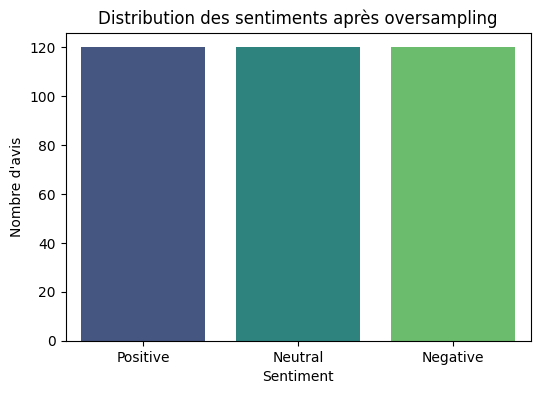

C:\Users\user\AppData\Local\Temp\ipykernel_15496\3796027931.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='review_length', data=df_resampled, palette='viridis')


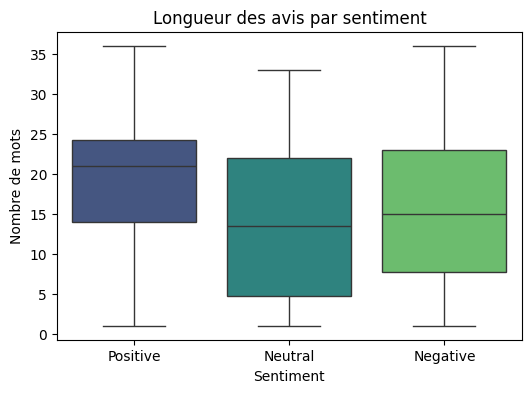

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisation de la distribution après rééquilibrage
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df_resampled, palette='viridis')
plt.title("Distribution des sentiments après oversampling")
plt.xlabel("Sentiment")
plt.ylabel("Nombre d'avis")
plt.show()

# Exemple : voir la longueur moyenne des avis par classe
df_resampled['review_length'] = df_resampled['processed_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
sns.boxplot(x='sentiment', y='review_length', data=df_resampled, palette='viridis')
plt.title("Longueur des avis par sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Nombre de mots")
plt.show()


In [10]:
# Sauvegarde du dataset rééquilibré
df_resampled.to_csv('cleaned_hotel_reviews_balanced.csv', index=False, encoding='utf-8')
print("Dataset rééquilibré sauvegardé !")

Dataset rééquilibré sauvegardé !


# modeles a tester

In [11]:
# Modèles à tester
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Multinomial Naive Bayes": MultinomialNB(),
    "SVM (Linear)": SVC(kernel='linear')
}

In [12]:

# K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Évaluation avec cross-validation
mean_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X_res, y_res, cv=kf, scoring='accuracy')
    mean_scores[name] = scores.mean()
    print(f"{name} - Accuracy scores : {scores}")
    print(f"{name} - Mean accuracy : {scores.mean():.4f}\n")

# Choisir le meilleur modèle
best_model_name = max(mean_scores, key=mean_scores.get)
print(f" Meilleur modèle : {best_model_name} avec accuracy moyenne = {mean_scores[best_model_name]:.4f}")

# Entraîner le meilleur modèle sur tout le dataset rééquilibré
best_model = models[best_model_name]
best_model.fit(X_res, y_res)

# Évaluation globale
y_pred = best_model.predict(X_res)
print("\nAccuracy (tout dataset) :", accuracy_score(y_res, y_pred))
print("F1-score (weighted) :", f1_score(y_res, y_pred, average='weighted'))
print("\nClassification report :\n", classification_report(y_res, y_pred))

# Sauvegarde
joblib.dump(best_model, f'{best_model_name}_balanced_model.pkl')
joblib.dump(tfidf_vect, 'tfidf_vectorizer_balanced.pkl')
print("Modèle et TF-IDF vectorizer rééquilibrés sauvegardés !")

Logistic Regression - Accuracy scores : [0.91666667 0.86111111 0.86111111 0.93055556 0.88888889]
Logistic Regression - Mean accuracy : 0.8917

Multinomial Naive Bayes - Accuracy scores : [0.875      0.86111111 0.79166667 0.875      0.79166667]
Multinomial Naive Bayes - Mean accuracy : 0.8389

SVM (Linear) - Accuracy scores : [0.90277778 0.88888889 0.875      0.93055556 0.90277778]
SVM (Linear) - Mean accuracy : 0.9000

 Meilleur modèle : SVM (Linear) avec accuracy moyenne = 0.9000

Accuracy (tout dataset) : 0.9944444444444445
F1-score (weighted) : 0.9944444444444445

Classification report :
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       120
     Neutral       0.99      0.99      0.99       120
    Positive       0.99      0.99      0.99       120

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360

Modèle et TF-IDF vec

In [ ]:
# Exemples de nouveaux avis
from text_utils import process_review

new_reviews = [
    "magnifique et accueillant.",
    "sale et déplorable.",
    "  service pas extraordinaire et classique."
]

# Prétraitement identique
def preprocess_text(text):
    tokens = process_review(text)
    return ' '.join(tokens)

new_texts = [preprocess_text(r) for r in new_reviews]

# TF-IDF transformation
X_new = tfidf_vect.transform(new_texts)

# Prédiction
predictions = best_model.predict(X_new)
for review, pred in zip(new_reviews, predictions):
    print(f"Review: {review}\nPredicted sentiment: {pred}\n")


Review: magnifique et accueillant.
Predicted sentiment: Neutral

Review: sale et déplorable.
Predicted sentiment: Neutral

Review:   service pas extraordinaire et classique.
Predicted sentiment: Positive



In [27]:
# Vérifier si les mots sont dans le vocabulaire
vocab = tfidf_vect.vocabulary_

print("Magnifique est-il connu ?", "magnif" in vocab or "magnifique" in vocab)
print("Déplorable est-il connu ?", "déplor" in vocab or "deplor" in vocab)
print("Sale est-il connu ?", "sale" in vocab)

Magnifique est-il connu ? True
Déplorable est-il connu ? False
Sale est-il connu ? False


In [45]:
# Exemples de nouveaux avis
#2
from text_utils import process_review

new_reviews = [
    "Un personnel excellent et très accueillant",
    "il est situé au centre ville de Tunis.",
    "cher, chambre bruitée , tres deconseillée.",
]

# Prétraitement identique
def preprocess_text(text):
    tokens = process_review(text)
    return ' '.join(tokens)

new_texts = [preprocess_text(r) for r in new_reviews]

# TF-IDF transformation
X_new = tfidf_vect.transform(new_texts)

# Prédiction
predictions = best_model.predict(X_new)
for review, pred in zip(new_reviews, predictions):
    print(f"Review: {review}\nPredicted sentiment: {pred}\n")


Review: Un personnel excellent et très accueillant
Predicted sentiment: Positive

Review: il est situé au centre ville de Tunis.
Predicted sentiment: Neutral

Review: cher, chambre bruitée , tres deconseillée.
Predicted sentiment: Negative



Les prédictions sur des avis individuels peuvent parfois sembler contre-intuitives, car les labels de sentiment ont été générés automatiquement par TextBlob-FR. Cette approche est rapide et pratique pour créer un dataset labellisé, mais elle introduit des erreurs sur certains avis, surtout ceux avec des expressions mixtes ou un vocabulaire spécifique.

# Explication
Ces prédictions surprenantes viennent du fait que les labels ont été générés automatiquement par TextBlob-FR et que certains avis ont des mots ambigus ou peu polarité. Quelques points à retenir :

Pourquoi “magnifique” → Neutral ?

TextBlob-FR calcule une polarité globale du texte. Si le texte contient des mots positifs mais aussi des mots neutres ou contradictoires, la polarité peut rester faible et tomber dans la zone “Neutral” (entre -0.1 et 0.1 dans ton code).

Pourquoi “Chambre sale …” → Positive ?

Cela peut arriver si certains mots sont mal interprétés, ou si le mot “recommande” est considéré positif et fait basculer le score au-dessus de 0.1. C’est un artefact des labels automatiques, pas du modèle ML lui-même.

Ce que ça implique pour le projet :

Les modèles ML entraînés sur ces labels ne peuvent jamais être meilleurs que la qualité des labels.

Comme tes labels sont automatiques, certaines prédictions peuvent sembler “incohérentes” par rapport au sens humain.

Pour améliorer : il faudrait annoter manuellement un petit échantillon pour calibrer la polarité ou utiliser des lexiques plus adaptés au français et au contexte hôtelier. Ou bien utiliser des Models LLMs pour pouvoir labelliser correctement les data (méthode avancé c pas la peine de l'utiliser)  

# Final Remark: we can use unsupervised ml to create clusters on the reviews and visualize them only
# to be done if discussed 